# 4b. Classification Task: Using Machine Learning to Predict Retraction

## Introduction


This Notebook performs our **main classification task**. It uses some of the most common classifier models (logistic regressor, XGBoost Classifier, and Random Forest Classifier) to **predict what papers are at risk of retraction**, and the most common vectorizers (Bag of Words and tf idf) to convert text data into numbers that our models can process. 

The Notebook uses the corpus of abstracts that was generated in **Notebook 4a**.

The **workflow** of the notebook is set up as follows:

- Input: **one .csv file** with our corpus with text from both retracted and non-retracted papers.
- Output: **none**.

## Input / Output Parameters:

Input parameters:

In [8]:

# File path to corpus to train model

input_path = "../data/final_corpus.csv"

# File path for country codes dictionary

file_path_country_codes = "../data/country_codes_dictionary.csv"

## Importing Required Libraries

Let us start by importing the required libraries to implement our task:

In [9]:

# Import required libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import json
import os

from scipy.stats import norm

import time
from function_definitions import seconds_to_hms



## Data Preprocessing and Test-Train Split


We can now use the "target" column of our data frame to define our target variable and our features, in case we have them:

In [10]:

# Create data frame with all abstracts

df_all_abstracts = pd.read_csv(input_path, encoding='latin-1')

# Visualize data frame

df_all_abstracts


,abstract_text,target,doi,country,year,ret_flag
0,"""Holliday Junction Recognition Protein (HJURP)...",0,10.7150_ijbs.30904,CN,2019,False
1,"""Laryngeal carcinoma (LC) is one of the common...",1,10.1155_2021_5614861,CN,2021,False
2,"""Hepatitis C virus (HCV)-induced human hepatoc...",0,10.3892_ol.2018.8221,CN,2018,False
3,"""Recessive dystrophic epidermolysis bullosa (R...",0,10.1080_2000656x.2019.1661846,CN,2019,False
4,"""Several microRNAs (miRNAs or miRs) regulate c...",1,10.1152_ajpcell.00576.2019,CN,2020,False
...,...,...,...,...,...,...
12780,"""Background. The purpose of this study was to ...",1,10.1155_2022_7723425,CN,2022,False
12781,"""Black yeast members of the Herpotrichiellacea...",0,10.1007_s00248-010-9651-4,CN,2010,False
12782,"""We have recently shown the roles of an autoph...",1,10.4161_auto.29414,Unknown,2014,False
12783,"""Abstract Tongue squamous cell carcinoma (TSCC...",1,10.1002_jcb.27206,CN,2018,False


In [11]:
# Definte target and features

X = df_all_abstracts["abstract_text"]
y = df_all_abstracts["target"]

We are now ready to split our data set into a train and test portion:

In [12]:

# Split data into train and text sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization with CountVectorizer()


We can now go ahead and vectorize our whole corpus using the bag of words method. First we generate our vocabulary by applyzing a Count Vectorizer to our train data set:

In [13]:

# Instantiate CountVectorizer 

vectorizer = CountVectorizer()

# Fit vectorizer to corpus of fraudulent papers to create bag of words vectors

X_train_vec = vectorizer.fit_transform(X_train)

# Obtain vocabulary for corpus

print("Vocabulary:")
print(vectorizer.get_feature_names_out())

# Print bag of words vectors for each document in corpus

print("\nBag of Words vectors:")
print(X_train_vec.toarray())

Vocabulary:
['00' '000' '0000' ... 'zyxin' 'zyxincdk8yap' 'zz']

Bag of Words vectors:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


- And now we use that vocabulary to vectorize our test data set:

In [14]:

# Vectorize test data set by using our vectorizer

X_test_vec = vectorizer.transform(X_test)

## Vectorization with TF-IDF


We can also try and vectorize our corpus using TF-IDF instead. Again, we start by applying the vectorizer to our train data set:

In [15]:

# Instantiate CountVectorizer 

tfidf = TfidfVectorizer()

# Fit vectorizer to corpus of fraudulent papers to create bag of words vectors

X_train_tfidf = tfidf.fit_transform(X_train)

# Obtain vocabulary for corpus

print("Vocabulary:")
print(tfidf.get_feature_names_out())

# Print bag of words vectors for each document in corpus

print("\nTF-IDF vectors:")
print(X_train_tfidf.toarray())

Vocabulary:
['00' '000' '0000' ... 'zyxin' 'zyxincdk8yap' 'zz']

TF-IDF vectors:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- And we then use the vocabulary generated from the train data set to vectorize out test data set:

In [16]:

# Vectorize test data set using vocabulary from train

X_test_tfidf = tfidf.transform(X_test)

## K-Best Analysis 

In [17]:

# Instantiate select k best 

k_best = SelectKBest(score_func=f_classif, k=20)  

# Fit select k best to training data 

X_train_selected_vec = k_best.fit_transform(X_train_vec, y_train)

# Get indices of k most salient feature

selected_feature_indices = k_best.get_support(indices=True)

# Obtain words corresponding to each index from vectorizer

features_list = vectorizer.get_feature_names_out()


# Obtain words corresponding to most salient features from index

selected_feature_names = [features_list[i] for i in selected_feature_indices]

# Visualize most salient words

selected_feature_names

# Obtain scores of selected features
selected_feature_scores = k_best.scores_[selected_feature_indices]

# Pair feature names with their corresponding scores
feature_scores = list(zip(selected_feature_names, selected_feature_scores))

# Print feature names and scores
for feature_name, score in feature_scores:
    print(f"Feature: {feature_name}, Score: {score}")

Feature: assay, Score: 562.8386925558563
Feature: blot, Score: 334.16805797536574
Feature: conclusion, Score: 380.6356753508398
Feature: cytometry, Score: 296.28453827402717
Feature: effects, Score: 270.6477170863405
Feature: endoplasmic, Score: 287.8175345575641
Feature: expression, Score: 524.2100213096338
Feature: inhibited, Score: 284.6110867256805
Feature: invasion, Score: 487.33728244661535
Feature: luciferase, Score: 346.00668538248544
Feature: mir, Score: 694.2313813015687
Feature: proliferation, Score: 395.46173845852206
Feature: reporter, Score: 272.2169474020555
Feature: reticulum, Score: 275.4843533964375
Feature: species, Score: 283.0694943534571
Feature: target, Score: 352.2809654854671
Feature: tissues, Score: 386.15779971035437
Feature: transwell, Score: 342.1488245101332
Feature: was, Score: 344.5727309669859
Feature: western, Score: 393.14900291686547


In [18]:

# Create a boolean mask to filter rows where "assay" is present in the "abstract_text" column
mask = df_all_abstracts["abstract_text"].str.contains("western")

# Apply the mask to filter rows
filtered_rows = df_all_abstracts[mask]

# Display the filtered rows
print(filtered_rows)

                                           abstract_text  target  \
9      "Benign prostatic hypertrophy (BPH) has become...       1   
36     "We examined the effects of microRNA-27a (miR-...       1   
37     "A pH sensitive micellar cargo was fabricated ...       1   
50     "(Mol Ther Nucleic Acids. 20  265278  June 5  ...       1   
88     "Gallium(III)-based drugs have gained momentum...       0   
...                                                  ...     ...   
12728  "Mitochondrial dysfunction has been implicated...       0   
12746  "Hyperglycemia induces retinal pigmented epith...       1   
12749  "Abstract MicroRNAs are deemed as key regulato...       1   
12763  "Nicotine  an active ingredient in tobacco  ca...       0   
12764  "Cerebral ischemia is considered to be the mos...       1   

                              doi  country  year  ret_flag  
9        10.1177_2058738418812349       CN  2018     False  
36              10.1159_000487560       CN  2018     False  


In [19]:
df_all_abstracts.iloc[9].abstract_text

'"Benign prostatic hypertrophy (BPH) has become a troublesome disease for elder men. Triptolide (TPL) has been reported to be a potential anticancer agent. However  the potential effects of TPL on BPH have not been shown out. BPH-1 cells were treated with different concentrations of TPL and/or transfected with microRNA-218 (miR-218) inhibitor  pc-survivin  sh-survivin  or their corresponding controls (NC). Thereafter  cell viability was determined by CCK-8 assay. Cell migration was accessed by modified two-chamber migration assay. Cell apoptosis was checked by propidium iodide (PI) and fluorescein isothiocyanate (FITC)-conjugated Annexin V staining. In addition  messenger RNA (mRNA) and protein levels were detected using quantitative real-time polymerase chain reaction (qRT-PCR) and western blot analysis  respectively. BPH-1 cell viability and migration were significantly decreased  while cell apoptosis and expression of miR-218 were statistically enhanced by TPL ( P   0.05 or P   0.01

## Classification with Logistic Regression

- We can now instantiate our model, fit it to our train data, and use it to obtain predictions for our test data:

In [20]:


# Instantiate logistic regressor

log_reg = LogisticRegression(max_iter = 200)

# Store start time of loop execution

start_time = time.time()

# Fit logistic regressor to our train data set

#log_reg.fit(X_train_vec, y_train)

log_reg.fit(X_train_tfidf, y_train)

# Use logistic regressor to obtain predictions for test data set

#y_pred = log_reg.predict(X_test_vec)

y_pred = log_reg.predict(X_test_tfidf)

# And for train data set

#y_pred_train = log_reg.predict(X_train_vec)

y_pred_train = log_reg.predict(X_train_tfidf)

# Calculate elapsed time for for training model

elapsed_time = time.time() - start_time

# Convert time to hours, minutes, and seconds

elapsed_hours, elapsed_minutes, elapsed_seconds = seconds_to_hms(elapsed_time)

# Print message with elapsed time

print(f"Time taken to train the model: {elapsed_hours}h, {elapsed_minutes}m, {elapsed_seconds}s. \n")


Time taken to train the model: 0.0h, 0.0m, 0.04795503616333008s. 




- Finally let us see how well our model is performing by obtaining some evaluations metrics for it:

In [21]:

# Obtain accuracy score and other evaluation metrics

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

report_test = classification_report(y_test, y_pred)

report_train = classification_report(y_train, y_pred_train)

# Print scores

print("Accuracy on train data set:", accuracy_train)
print("Accuracy on test data set:", round(accuracy_test,2))

print("Classification Report for Train:\n", report_train)

print("Classification Report for Test:\n", report_test)

Accuracy on train data set: 0.9340046929996089
Accuracy on test data set: 0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      5306
           1       0.93      0.93      0.93      4922

    accuracy                           0.93     10228
   macro avg       0.93      0.93      0.93     10228
weighted avg       0.93      0.93      0.93     10228

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1322
           1       0.87      0.87      0.87      1235

    accuracy                           0.88      2557
   macro avg       0.88      0.88      0.88      2557
weighted avg       0.88      0.88      0.88      2557



- And the confusion matrix:

In [22]:

# Obtain confusion matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred)

print("Confusion Matrix for Log Reg:\n", conf_matrix_log_reg)


Confusion Matrix for Log Reg:
 [[1166  156]
 [ 159 1076]]



- Let us also find out what the values of the coefficients associated to the different features are:

In [23]:
# Obtain coefficients for logistic regressor

coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_

# Obtain feature names from vocabulary

feature_names = vectorizer.get_feature_names_out()

# Pair each feature with its coefficient

coefficients_with_features = list(zip(feature_names, coefficients))

# Sort coefficients based on absolute values

sorted_coefficients = sorted(coefficients_with_features, key=lambda x: abs(x[1]), reverse=True)

# Print the top 10 coefficients along with their corresponding features

print("Top 20 coefficients with largest absolute magnitude:")
for i, (feature, coefficient) in enumerate(sorted_coefficients[:15], start=1):
    print(f"{i}. Feature: {feature}, Coefficient: {coefficient}")
    

Top 20 coefficients with largest absolute magnitude:
1. Feature: yap, Coefficient: -7.071505713136368
2. Feature: mir, Coefficient: 5.110856450838145
3. Feature: er, Coefficient: -4.649505147045536
4. Feature: hippo, Coefficient: -4.481274725960628
5. Feature: yap1, Coefficient: -4.431565216210719
6. Feature: vitiligo, Coefficient: -4.376600092553718
7. Feature: zebrafish, Coefficient: -4.322598561812992
8. Feature: stress, Coefficient: -3.95279826034128
9. Feature: species, Coefficient: -3.658334848854043
10. Feature: taz, Coefficient: -3.499560255358231
11. Feature: grp78, Coefficient: -3.449740958543295
12. Feature: tyrosinase, Coefficient: -3.313482746889907
13. Feature: taurine, Coefficient: -3.1522022503981035
14. Feature: endoplasmic, Coefficient: -3.0833712143664713
15. Feature: rats, Coefficient: 3.0122394662095235


- Let us create a word cloud:

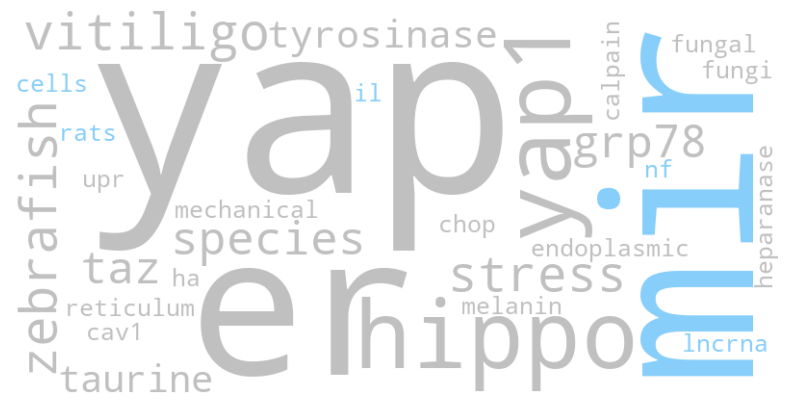

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sort coefficients by absolute value
sorted_coefficients = sorted(sorted_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Select the top 30 words
top_words = sorted_coefficients[:30]

# Separate words with positive and negative coefficients
positive_words = [word for word, coeff in top_words if coeff > 0]
negative_words = [word for word, coeff in top_words if coeff < 0]

# Generate word cloud with custom color function
def fixed_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in positive_words:
        # Set color to light blue for positive coefficients
        return "rgb(135, 206, 250)"  # Light blue color
    elif word in negative_words:
        # Set color to light grey for negative coefficients
        return "rgb(192, 192, 192)"  # Light grey color
    else:
        # Default color for neutral words
        return "rgb(128, 128, 128)"  # Default grey color

# Convert top_words into a dictionary
word_freq_dict = {word: abs(coeff) for word, coeff in top_words}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=fixed_color_func)
wordcloud.generate_from_frequencies(word_freq_dict)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Classification with XGBoost

- Let us start by instantiating our model:

In [25]:
xgboost = XGBClassifier()

- And by fitting it to our vectorized train data set:

In [26]:
xgboost.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- We can now go on to make predictions with our trained model:

In [27]:

# Predictions for the test data set

y_pred_xgb = xgboost.predict(X_test_tfidf)

# And for train data set

y_pred_train_xgb = xgboost.predict(X_train_tfidf)


- Let us now and see how are model performs

In [28]:

# Obtain accuracy score and other evaluation metrics

accuracy_test_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_train_xgb = accuracy_score(y_train, y_pred_train_xgb)

report_test_xgb = classification_report(y_test, y_pred_xgb)

report_train_xgb = classification_report(y_train, y_pred_train_xgb)

# Print scores

print("Accuracy on train data set (XGB Classifier):", accuracy_train_xgb)
print("Accuracy on test data set (XGB Classifier):", round(accuracy_test_xgb,2))

print("Classification Report for Train (XGB Classifier):\n", report_train_xgb)

print("Classification Report for Test (XGB Classifier):\n", report_test_xgb)

Accuracy on train data set (XGB Classifier): 0.9653891278842394
Accuracy on test data set (XGB Classifier): 0.87
Classification Report for Train (XGB Classifier):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5306
           1       0.95      0.97      0.96      4922

    accuracy                           0.97     10228
   macro avg       0.97      0.97      0.97     10228
weighted avg       0.97      0.97      0.97     10228

Classification Report for Test (XGB Classifier):
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      1322
           1       0.86      0.87      0.86      1235

    accuracy                           0.87      2557
   macro avg       0.87      0.87      0.87      2557
weighted avg       0.87      0.87      0.87      2557



- Same for XGBoost

In [29]:

# Obtain confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Confusion Matrix XGB Classifier:\n", conf_matrix_xgb)


Confusion Matrix XGB Classifier:
 [[1151  171]
 [ 165 1070]]


## Classification with Random Forest

In [30]:

# Configuration of the RandomForest Classifier
clf = RandomForestClassifier(
    n_estimators=8000,
    max_depth=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Start timing for fitting the model
start_time = time.time()
clf.fit(X_train_tfidf, y_train)
end_time = time.time()
fit_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(fit_time)
print(f"Training completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")

# Start timing for making predictions
start_time = time.time()
y_pred_rf = clf.predict(X_test_tfidf)
y_pred_train_rf = clf.predict(X_train_tfidf)
end_time = time.time()
predict_time = end_time - start_time
hours, minutes, seconds = seconds_to_hms(predict_time)
print(f"Prediction completed in: {hours} hours, {minutes} minutes, and {seconds:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)


Training completed in: 0.0 hours, 0.0 minutes, and 9.66 seconds
Prediction completed in: 0.0 hours, 0.0 minutes, and 1.74 seconds
Accuracy: 0.7770825185764568


In [31]:
# Get feature importances from the trained model
importances = clf.feature_importances_

# Get feature names from the vectorizer
feature_names = tfidf.get_feature_names_out()

# Define the number of top features you want to display
K = 20

# Get the indices of the K most important features in descending order of importance
indices = importances.argsort()[-K:][::-1]

# Display the top K important features with their names and importance scores
top_features = [(feature_names[i], importances[i]) for i in indices]
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")

mir: 0.0109
expression: 0.0090
assay: 0.0079
was: 0.0067
endoplasmic: 0.0067
reticulum: 0.0066
cells: 0.0064
luciferase: 0.0061
apoptosis: 0.0056
western: 0.0055
invasion: 0.0055
cell: 0.0055
yap: 0.0054
is: 0.0053
proliferation: 0.0053
er: 0.0049
hippo: 0.0049
cancer: 0.0047
species: 0.0047
tumor: 0.0046


In [32]:

# Define function to fit & rpedict random forest


def train_and_log_rf(n_estimators, max_depth, train_data, train_labels, test_data, test_labels):
    # Configuration of the RandomForest Classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    # Start timing for fitting the model
    start_time = time.time()
    clf.fit(train_data, train_labels)
    fit_time = time.time() - start_time  # Time in seconds
    print(f"Training Time: {fit_time:.2f} seconds")

    # Start timing for making predictions
    start_time = time.time()
    y_pred = clf.predict(test_data)
    predict_time = time.time() - start_time  # Time in seconds
    print(f"Prediction Time: {predict_time:.2f} seconds")

    # Evaluate the model
    accuracy = accuracy_score(test_labels, y_pred)
    print("Accuracy:", accuracy)

    # Prepare data for logging
    log_data = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'training_time': f"{fit_time:.2f} seconds",
        'prediction_time': f"{predict_time:.2f} seconds",
        'accuracy': accuracy
    }
    log_df = pd.DataFrame([log_data])

    # Define log file path
    log_file_path = '../data/model_logs/model_performance_log.csv'

    # Check if the directory exists, if not, create it
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)

    # Check if file exists, append if it does, otherwise write a new file
    if os.path.isfile(log_file_path):
        log_df.to_csv(log_file_path, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_file_path, mode='w', header=True, index=False)

    # Return the model, predictions, and accuracy
    return clf, y_pred, accuracy



In [33]:
# Define number of trees & tree depth and instatiate fitting the model and making the predicitons

num_trees = 4000
tree_depth = 40

clf, y_pred_rf, accuracy_rf = train_and_log_rf(num_trees, tree_depth, X_train_tfidf, y_train, X_test_tfidf, y_test)


Training Time: 10.43 seconds
Prediction Time: 0.28 seconds
Accuracy: 0.798201016816582


In [34]:

# Calculate accuracy just for train

accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
print(f"Accuracy: {accuracy_train_rf:.2f}")

# Generate and print classification report for train

report_train_rf = classification_report(y_train, y_pred_train_rf)
print("Classification Report:")
print(report_train_rf)

Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      5306
           1       0.94      0.83      0.89      4922

    accuracy                           0.90     10228
   macro avg       0.90      0.89      0.90     10228
weighted avg       0.90      0.90      0.90     10228



In [35]:

# Calculate accuracy just for test

accuracy_test_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_test_rf:.2f}")

# Generate and print classification test

report_test_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(report_test_rf)

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1322
           1       0.83      0.73      0.78      1235

    accuracy                           0.80      2557
   macro avg       0.80      0.80      0.80      2557
weighted avg       0.80      0.80      0.80      2557



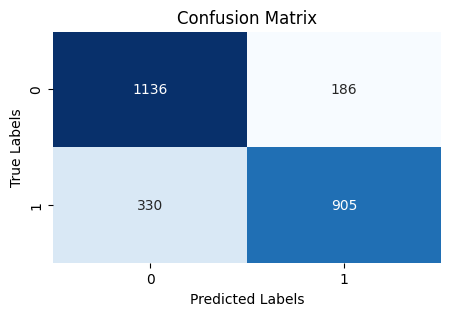

In [36]:
# Assign
cm = confusion_matrix(y_test, y_pred_rf)


# Plotting the heatmap
plt.figure(figsize=(5, 3))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # 'fmt' is a string format code
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ROC Curve for all three Models 


- Let us also obtain ROC score and visualize the ROC curve for our regressor:

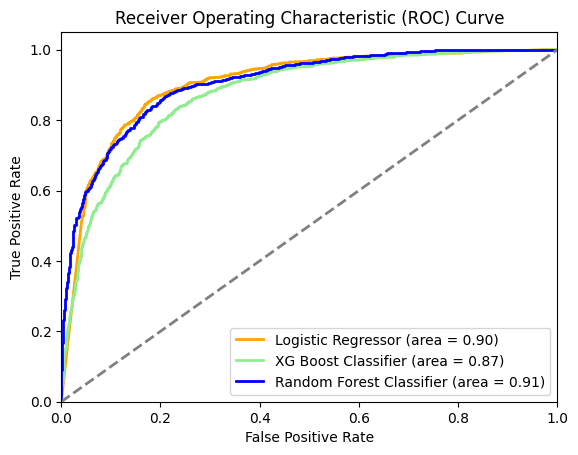

In [37]:

# Obtain predicted probabilities for positive class (Log Reg)

y_pred_proba = log_reg.predict_proba(X_test_vec)[:, 1]

# Obtain predicted probabilities for positive class (XGB classifier)

y_pred_proba_xgb = xgboost.predict_proba(X_test_vec)[:, 1]

# Obtain predicted probabilities for positive class (random forest classifier)

y_pred_proba_rf = clf.predict_proba(X_test_vec)[:, 1]

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Compute Area Under the Curve (AUC)

roc_auc = auc(fpr, tpr)

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

roc_auc_rf = auc(fpr_rf, tpr_rf)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='Logistic Regressor (area = %0.2f)' % roc_auc)
plt.plot(fpr_xgb, tpr_xgb, color='lightgreen', lw=2, label='XG Boost Classifier (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest Classifier (area = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



## Model Performance for Different Countries


-Finally, let us also make sure that our model gives comparable predictions for papers from different years and countries. Let us start with China:

In [38]:

# Obtain only abstracts for papers from China and store them in data frame

df_ch = df_all_abstracts[df_all_abstracts["country"] == "CN"]

# Visualize shape of filtered array

print(df_ch.shape)

# Vectorize text for those papers using TF-IDF vectorization

X_ch_tfidf = tfidf.transform(df_ch["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_ch = log_reg.predict(X_ch_tfidf)

(7031, 6)


In [39]:

# Obtain number of papers flagged as fraudulent

y_pred_ch.sum()

np.int64(3670)

In [40]:

# Obtain number of papers that we tested in total

len(y_pred_ch)

7031

In [41]:

# Compute percentage of papers flagged as fraudulent for China

per_fraud_china = y_pred_ch.sum() / len(y_pred_ch) * 100

# Visualize result

per_fraud_china 

np.float64(52.197411463518705)

In [42]:
df_ch_fraud = df_ch[df_ch["target"] == 1]

In [43]:
df_ch_fraud.shape

(3400, 6)

In [44]:
df_ch_fraud.shape[0] / df_ch.shape[0] * 100

48.35727492533068

- Let us now repeat the same steps for the US:

In [45]:

# Obtain only abstracts for papers from China and store them in data frame

df_us = df_all_abstracts[df_all_abstracts["country"] == "US"]

# Visualize shape of filtered array

print(df_us.shape)

# Vectorize text for those papers using TF-IDF vectorization

X_us_tfidf = tfidf.transform(df_us["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_us = log_reg.predict(X_us_tfidf)

(2069, 6)


In [46]:

# Compute percentage of papers flagged as fraudulent for China

per_fraud_us = y_pred_us.sum() / len(y_pred_us) * 100

# Visualize result

per_fraud_us

np.float64(39.53600773320445)

In [47]:
df_us_fraud = df_us[df_us["target"] == 1]

In [48]:
df_us_fraud.shape[0] / df_us.shape[0] * 100

44.70758820686322


- It will be easier to simply write a function that performs all these operations for future use:

In [77]:

def model_tester_country(country_code, df, vectorizer, model):
    
    # Obtain only abstracts for papers from China and store them in data frame

    df_filtered = df[df["country"] == country_code]

    # Check if we have at least one abstract to process
    
    if df_filtered.empty:
        print(f"No abstracts found for {country_code}. Skipping.")
        return (None, None)

    # Vectorize text for those papers using TF-IDF vectorization

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with logistic reg model

    y_pred_filtered = model.predict(X_filtered)
    
    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100

    # Print results
    
    #print(f"Perfectage of papers flagged for {country_code} {percentage_flagged}")
    #print(f"Perfectage of fraudulent papers for {country_code} {percentage_fraud}")
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
 

- Let us test it to make sure it works OK:

In [50]:

# Calculate percentage of papers flagged for US

model_tester_country("US", df_all_abstracts, tfidf, log_reg)

(np.float64(39.53600773320445), 44.70758820686322, np.int64(818), 925)

In [51]:

# Now for China

model_tester_country("CN", df_all_abstracts, tfidf, log_reg)

(np.float64(52.197411463518705), 48.35727492533068, np.int64(3670), 3400)

In [52]:

# UK

model_tester_country("GB", df_all_abstracts, tfidf, log_reg)

(np.float64(31.963470319634702), 38.81278538812785, np.int64(70), 85)

In [53]:

# India

model_tester_country("IN", df_all_abstracts, tfidf, log_reg)

(np.float64(44.09221902017291), 47.55043227665706, np.int64(153), 165)

In [54]:

# Iran

model_tester_country("IR", df_all_abstracts, tfidf, log_reg)

(np.float64(63.63636363636363), 60.3896103896104, np.int64(98), 93)

In [55]:
# France

model_tester_country("AU", df_all_abstracts, tfidf, log_reg)

(np.float64(33.33333333333333), 40.74074074074074, np.int64(27), 33)

- Let us run a similar quality test for our year breakdown:

In [56]:

def model_tester_year(year, df, vectorizer, model):
    
    # Obtain only abstracts for papers from China and store them in data frame

    df_filtered = df[df["year"] == year]

    # Vectorize text for those papers using TF-IDF vectorization

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with logistic reg model

    y_pred_filtered = model.predict(X_filtered)

    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
 

In [57]:
model_tester_year(2020, df_all_abstracts, tfidf, log_reg)

(np.float64(49.200833912439194), 45.448227936066715, np.int64(708), 654)

In [58]:
model_tester_year(2019, df_all_abstracts, tfidf, log_reg)

(np.float64(52.62832405689548), 49.474335188620906, np.int64(851), 800)

In [59]:
model_tester_year(2009, df_all_abstracts, tfidf, log_reg)

(np.float64(41.348973607038126), 48.38709677419355, np.int64(141), 165)


- Finally, let us create a function that allows us to run an analysis for both a country and a year of our choice:

In [60]:

def model_tester_year_country(year, country, df, vectorizer, model):
    
    # Obtain only abstracts for papers from a given bucket and store them in data frame

    df_filtered = df[(df["year"] == year) & (df["country"] == country)]

    # Vectorize text for those papers using our vectorizer

    X_filtered = vectorizer.transform(df_filtered["abstract_text"])

    # Obtain predictions for vectorized text with our model

    y_pred_filtered = model.predict(X_filtered)

    # Obtain total number of papers flagged
    
    total_flagged = y_pred_filtered.sum()

    # Compute percentage of papers flagged as fraudulent for country

    percentage_flagged = total_flagged / len(y_pred_filtered) * 100
    
    # Calculate total number of papers that are actually fraudulent for country
    
    total_fraud = df_filtered[df_filtered["target"] == 1].shape[0]
    
    # Calculate percentage of papers that are actually fraudulent for country
    
    percentage_fraud = total_fraud / df_filtered.shape[0] * 100

    # Print results
    
    #print(f"Perfectage of papers flagged for {year} and {country} {percentage_flagged}")
    #print(f"Perfectage of fraudulent papers for {year} and {country} {percentage_fraud}")
    
    return percentage_flagged, percentage_fraud, total_flagged, total_fraud
    

In [61]:

model_tester_year_country(2017, "CN", df_all_abstracts, tfidf, log_reg)

(np.float64(54.68164794007491), 49.56304619225968, np.int64(438), 397)

In [62]:

model_tester_year_country(2021, "US", df_all_abstracts, tfidf, log_reg)

(np.float64(32.35294117647059), 32.35294117647059, np.int64(11), 11)

In [63]:

model_tester_year_country(2018, "IR", df_all_abstracts, tfidf, log_reg)

(np.float64(70.0), 70.0, np.int64(7), 7)

- Let us try a more systematic comparison for all countries:

In [87]:
df_all_abstracts["country"] = df_all_abstracts["country"].fillna("Unknown")

#temporary fix maybe remove later


In [88]:

countries = df_all_abstracts["country"].unique()
results = []
difference_percentage = []
difference_total = []

for country in countries:
    country_results = model_tester_country(country, df_all_abstracts, tfidf, log_reg)
    if country_results is None or len(country_results) < 4:
        print(f"Skipping {country} due to insufficient data.")
        continue
    results.append(country_results)
    difference_percentage.append(country_results[0] - country_results[1])
    difference_total.append(country_results[2] - country_results[3])



In [89]:


df_differences = pd.DataFrame({"country": countries, "percentage_difference": difference_percentage, "total_difference": difference_total})

In [90]:

df_differences = df_differences[df_differences["total_difference"] != 0]

<Axes: xlabel='country'>

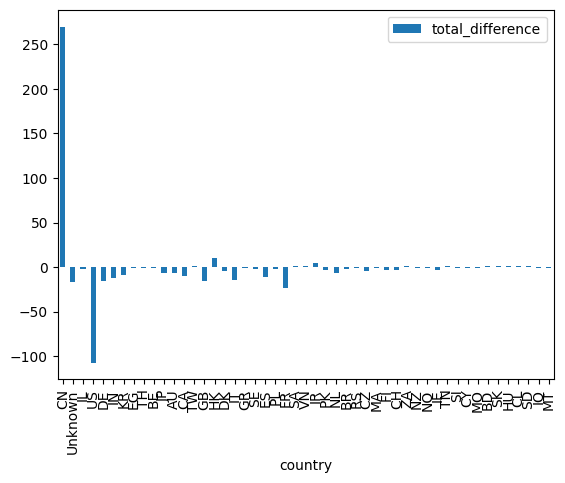

In [91]:

df_differences.plot.bar(x="country", y="total_difference")


In [92]:

# Obtain size of data frame to decide how to filter top entires

df_differences.shape

(49, 3)

In [93]:

# Filter data frame to obtain countries with most papers in absolute number only 

df_differences_filtered = df_differences.head(27)

<Axes: xlabel='country'>

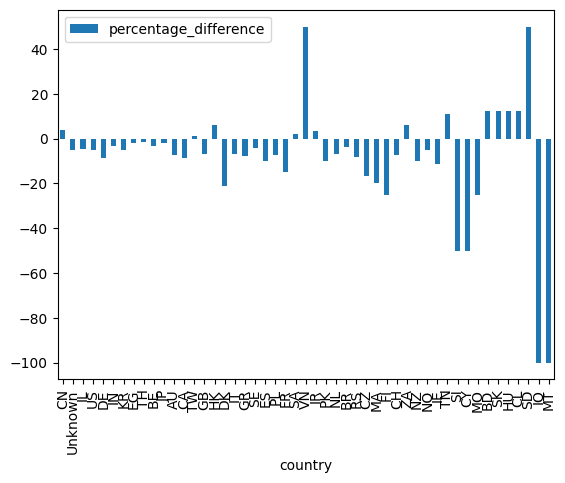

In [94]:

# Make normal plot

df_differences.plot.bar(x="country", y="percentage_difference")


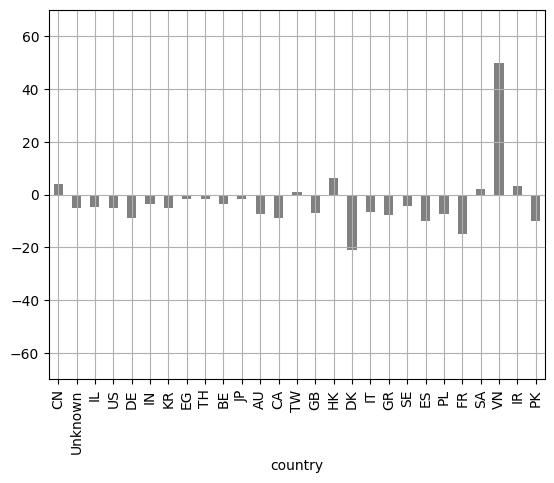

In [95]:

# Make plot for filtered data frame

ax = df_differences_filtered.plot.bar(x="country", y="percentage_difference", color='grey', legend=False)

# Set the y axis to -50 and 50 percentage points

ax.set_ylim(-70, 70)

# Add grid

ax.grid(True)

# Display plot

plt.show()


- And now for all years:

In [96]:

year_results = model_tester_year(2020, df_all_abstracts, tfidf, log_reg)


In [97]:
years = df_all_abstracts["year"].unique()
results_year = []
difference_percentage_year = []
difference_total_year = []


    
for year in years:
    year_results = model_tester_year(year, df_all_abstracts, tfidf, log_reg)
    results_year.append(year_results)
    difference_percentage_year.append(year_results[0] - year_results[1])
    difference_total_year.append(year_results[2] - year_results[3])



In [98]:
df_differences_year = pd.DataFrame({"year": years, "percentage_difference": difference_percentage_year, "total_difference": difference_total_year})

In [99]:
df_differences_year.head(5)

,year,percentage_difference,total_difference
0,2019,3.153989,51
1,2021,0.883838,7
2,2018,2.934363,38
3,2020,3.752606,54
4,2015,3.468208,24


<Axes: xlabel='year'>

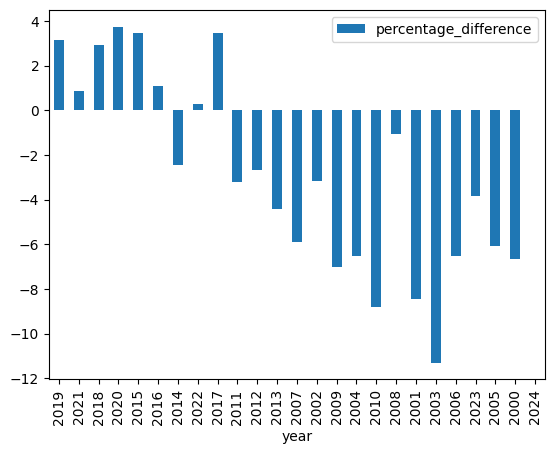

In [100]:
df_differences_year.plot.bar(x="year", y="percentage_difference")


<Axes: xlabel='year'>

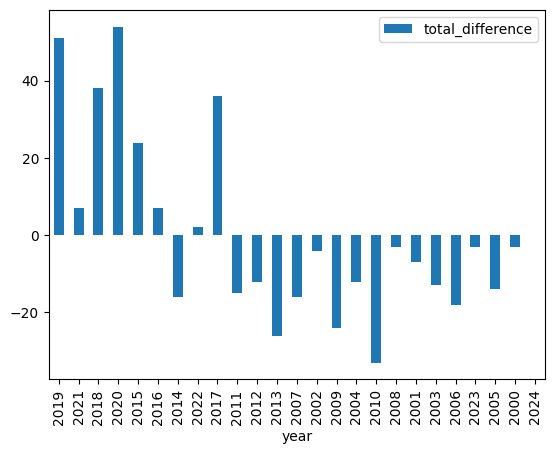

In [101]:

df_differences_year.plot.bar(x="year", y="total_difference")


-Let us get some scores and performance metrics per year and country too. First we'll try China:


In [102]:

df_china = df_all_abstracts[df_all_abstracts["country"] == "CN"]

# Vectorize text for those papers using TF-IDF vectorization

X_china = tfidf.transform(df_china["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_china = log_reg.predict(X_china)
    

In [103]:
y_china = df_china["target"]

report_test = classification_report(y_china, y_pred_china)

print("Classification Report for China:\n", report_test)

Classification Report for China:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      3631
           1       0.89      0.96      0.93      3400

    accuracy                           0.93      7031
   macro avg       0.93      0.93      0.93      7031
weighted avg       0.93      0.93      0.93      7031



In [104]:
conf_matrix_china = confusion_matrix(y_china, y_pred_china)

conf_matrix_china

array([[3237,  394],
       [ 124, 3276]])

- And then the US:

In [105]:

df_us = df_all_abstracts[df_all_abstracts["country"] == "US"]

# Vectorize text for those papers using TF-IDF vectorization

X_us = tfidf.transform(df_us["abstract_text"])

# Obtain predictions for vectorized text with logistic reg model

y_pred_us = log_reg.predict(X_us)
    

In [106]:
y_us = df_us["target"]

report_test_us = classification_report(y_us, y_pred_us)

print("Classification Report for the USA:\n", report_test_us)

Classification Report for the USA:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      1144
           1       0.96      0.85      0.91       925

    accuracy                           0.92      2069
   macro avg       0.93      0.91      0.92      2069
weighted avg       0.92      0.92      0.92      2069



In [107]:
conf_matrix_us = confusion_matrix(y_us, y_pred_us)

conf_matrix_us

array([[1115,   29],
       [ 136,  789]])